In [1]:
import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit

# Part 1

In [ ]:
r = cv2.imread('data/P01_Red.jpg',0)
g = cv2.imread('data/P01_Green.jpg',0)
b = cv2.imread('data/P01_Blue.jpg',0)

img = np.zeros((r.shape[0], r.shape[1], 3))

img = cv2.merge([b,g,r])
cv2.imwrite("RGB_Image.png", img)

[ WARN:0@100.260] global loadsave.cpp:275 findDecoder imread_('P01_Red.jpg'): can't open/read file: check file path/integrity
[ WARN:0@100.260] global loadsave.cpp:275 findDecoder imread_('P01_Green.jpg'): can't open/read file: check file path/integrity
[ WARN:0@100.260] global loadsave.cpp:275 findDecoder imread_('P01_Blue.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
rainbow = cv2.imread('Rainbow.jpg')
b,g,r = cv2.split(rainbow)

for i,j in zip([b,g,r], ['b','g','r']): cv2.imwrite(f'Rainbow_{j}.png', i)

In [ ]:
rainbow = cv2.imread('Rainbow.jpg')

coords = [300,480] # y,x
channels = ['blue', 'green', 'red']

for channel,name in zip([0,1,2], channels): print(f'Channel {name}: {rainbow[coords[0]][coords[1]][channel]}')

In [ ]:
seqA = [str(p) for p in sorted(Path('SecuenciaA/').glob("*.tif"))]

def pixelValue(path, coords, verbose= False):
    values = []
    
    if verbose == True: 
        counter = 0
        print('Values in BGR')

    for file in path:
        img = cv2.imread(file)[coords[0]][coords[1]]
        values.append(img)

        if verbose == True:
            print(f'Image {counter}: {img}')
            counter += 1
    
    return values

res = pixelValue(seqA, [150,250], True)

In [ ]:
seqB = [str(p) for p in sorted(Path('SecuenciaB/').glob("*.tif"))]

def avgPixelValue(path, coords, lenght: int, verbose=False):
    values = []

    if verbose == True:
        counter = 0
        print(f'Average values in BGR for region from {coords} to {[coords[0]+lenght,coords[1]+lenght]}')

    for file in path:
        region = []
        for i in range(lenght):
            for j in range(lenght):
                # print(file)
                pixel_vals = pixelValue([file], [coords[0]+i,coords[1]+j])
                # print(pixel_vals[0])
                region.append(pixel_vals[0].tolist())
        
        averaged = [sum(values) / len(values) for values in zip(*region)]
        values.append(averaged)

        if verbose == True:
            print(f'Image {counter}: {averaged}')
            counter +=1

    return values

res = avgPixelValue(seqB, [150,250], 5, True)

# Malus

In [ ]:
points = [[100,100], [200,200], [300,300], [150,400], [450,230]]
dataPath = [str(p) for p in sorted(Path('Malus/').glob("*.tif"))]
angles = list(range(0, 361, 5))
space = np.linspace(0,361,500)

intensity = []
for point in points: intensity.append(avgPixelValue(dataPath, point, 5))

for i in range(len(intensity)): intensity[i] = [float(np.average(i)) for i in intensity[i]]

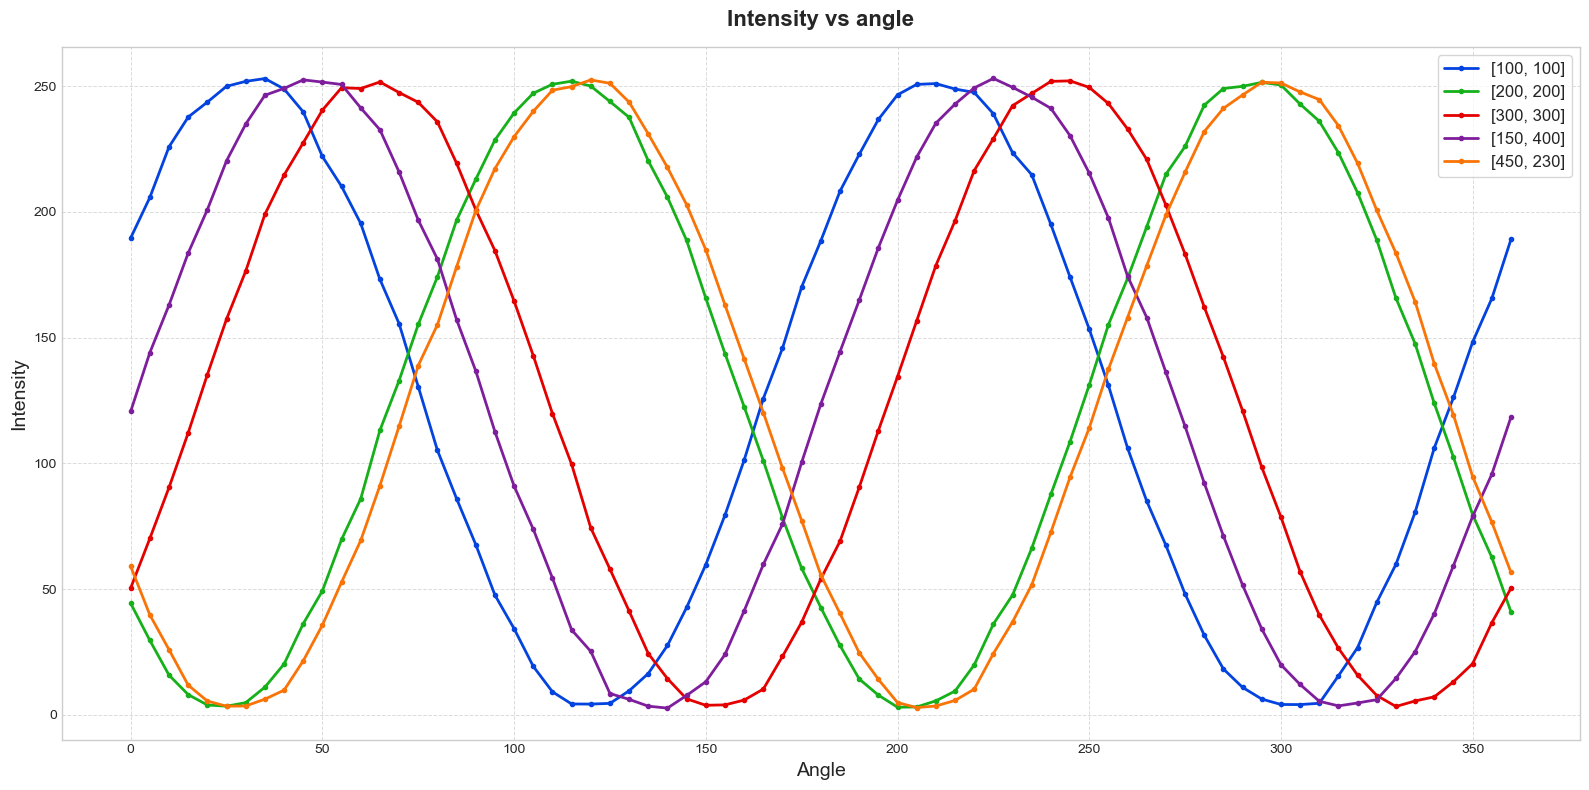

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')  # Modern style
fig, ax = plt.subplots(figsize=(16, 8))

for channel, color, coor in zip(intensity, ['blue', 'green', 'red', 'purple', 'orange'], [str(i) for i in points]):
    ax.plot(angles, channel, marker='.', linewidth=2, color=f'xkcd:{color}', label=f'{coor}', zorder=1)

ax.set_ylabel('Intensity', fontsize=14)
ax.set_xlabel('Angle', fontsize=14)
ax.set_title('Intensity vs angle', fontsize=16, fontweight='bold', pad=15)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax.legend(fontsize=12, loc='best', frameon=True)
plt.tight_layout()
# plt.savefig('Srel.png', dpi=300)
plt.show()

In [ ]:
def model(x, I0, a, b):
    return I0 * (np.cos(np.radians(x)+a)**2) + b

parameters = []
for point in intensity:
    popt, _ = curve_fit(model, angles, point)
    parameters.append(popt)

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')  # Modern style
fig, ax = plt.subplots(figsize=(16, 8))

for channel, param, color, coor in zip(intensity, parameters, ['blue', 'green', 'red', 'purple', 'orange'], [str(i) for i in points]):
    ax.scatter(angles, channel, marker='.', linewidth=2, color=f'xkcd:{color}', label=f'{coor}', zorder=1)
    ax.plot(space, model(space, *param), marker='.', linewidth=2, color=f'xkcd:{color}', label=f'{coor}', zorder=1)

ax.set_ylabel('Intensity', fontsize=14)
ax.set_xlabel('Angle', fontsize=14)
ax.set_title('Intensity vs angle', fontsize=16, fontweight='bold', pad=15)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax.legend(fontsize=12, loc='best', frameon=True)
plt.tight_layout()
# plt.savefig('Srel.png', dpi=300)
plt.show()

In [ ]:
# Initial angle
for a, coor in zip(parameters, [str(i) for i in points]):
    print(f'Initial angle for {coor}: {a[1]:.3f} rad')

## Initial angle map

In [ ]:
# OPTIMIZED VERSION
height, width, channels = cv2.imread(dataPath[0]).shape

# Load ALL images at once into a 4D array
all_images = []
for i, file in enumerate(dataPath):
    img = cv2.imread(file)
    all_images.append(img)

all_images = np.array(all_images)  # Shape: (num_angles, height, width, 3)
print(f"Loaded {all_images.shape[0]} images of size {all_images.shape[1:3]}")


# Extract intensity for each pixel position (downsampled)
step = 1  # Increase step size for faster processing
data = np.zeros((73, int(height/step), int(width/step)))

for i in range(0, height, step):
    for j in range(0, width, step):
        
        # Extract 4x4 region around each point and average
        region_size = step
        i_start = max(0, i)
        i_end = min(height, i + region_size)
        j_start = max(0, j)
        j_end = min(width, j + region_size)

        region_data = all_images[:, i_start:i_end, j_start:j_end, :]

        for k in range(0, len(all_images)):
            data[k][int(i/step)][int(j/step)] = np.mean(region_data[k])

print(f"Processed {data.shape} shape") 

Loaded 73 images of size (512, 512)
Processed (73, 512, 512) shape


In [118]:
nx, ny = data.shape[1], data.shape[2]
param_map = np.zeros((nx, ny))


for x in range(nx):
    for y in range(ny):
        intensity = data[:,x,y]

        try:
            popt, _ = curve_fit(model, angles, intensity)
            param_map[x, y] = popt[1]   # store parameter
        except RuntimeError:
            param_map[x, y] = np.nan    # fit failed

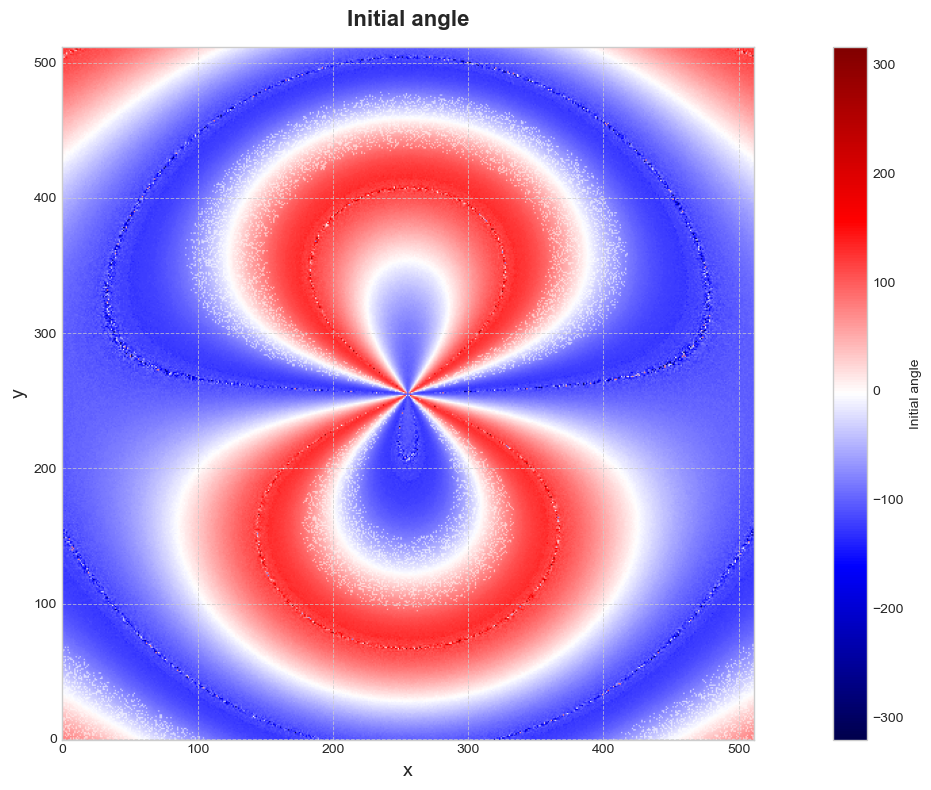

In [119]:
plt.style.use('seaborn-v0_8-whitegrid')  # Modern style
fig, ax = plt.subplots(figsize=(16, 8))

im = ax.imshow(param_map, cmap='seismic', origin='lower')
fig.colorbar(im, ax=ax, label="Initial angle")
ax.set_ylabel('y', fontsize=14)
ax.set_xlabel('x', fontsize=14)
ax.set_title('Initial angle', fontsize=16, fontweight='bold', pad=15)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
# plt.savefig('Srel.png', dpi=300)
plt.show()